In [1]:
#imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Data uploads
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
test  = pd.read_csv('test.csv').set_index('ID')

# Exploration, Outlier Handling, and Pre-processing

In [3]:
#descriptive stats for important variables
print("Descriptive statistics for 'item_price':")
print(train['item_price'].describe())
print("\nDescriptive statistics for 'item_cnt_day':")
print(train['item_cnt_day'].describe())

Descriptive statistics for 'item_price':
count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

Descriptive statistics for 'item_cnt_day':
count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


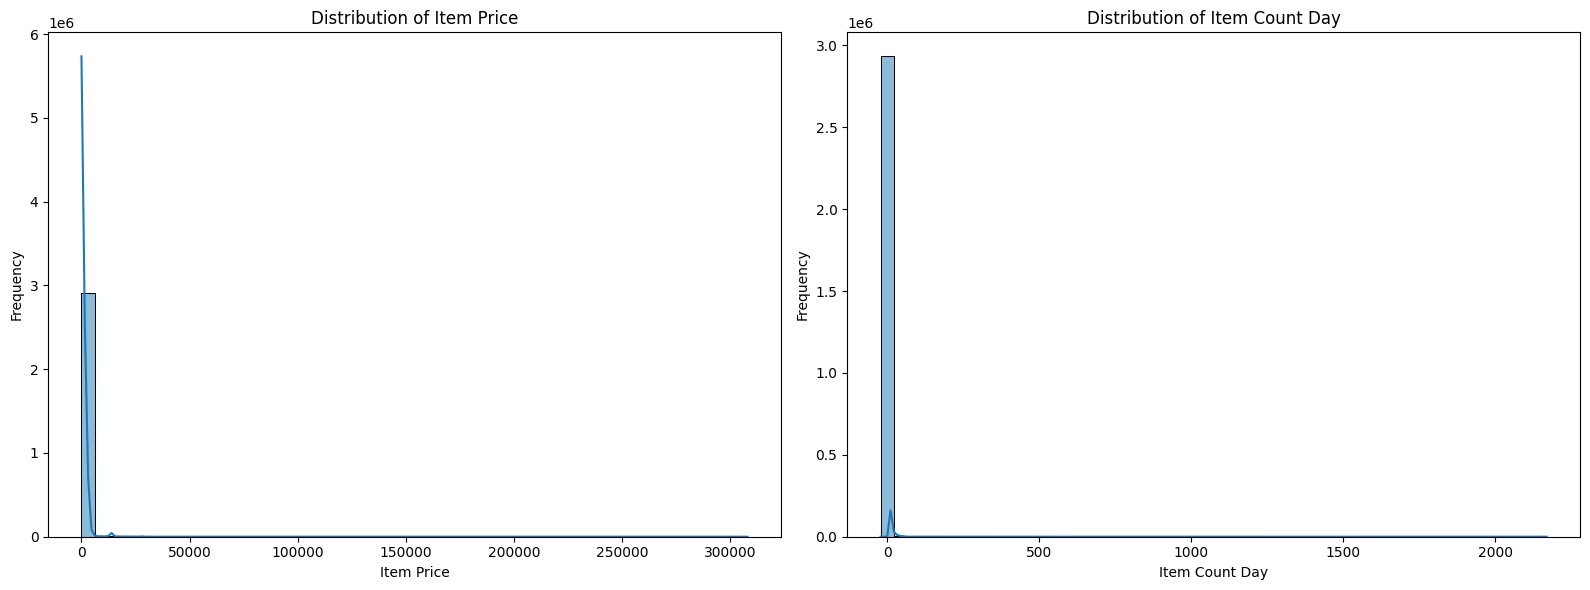

In [4]:
#Plot of distributions of price and item counts
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['item_price'], bins=50, kde=True)
plt.title('Distribution of Item Price')
plt.xlabel('Item Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(train['item_cnt_day'], bins=50, kde=True)
plt.title('Distribution of Item Count Day')
plt.xlabel('Item Count Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [5]:
#Outlier handling
print(f"Original shape of train: {train.shape}")

train = train[train['item_price'] <= 100000]
train = train[train['item_cnt_day'] <= 1001]

print(f"Shape of train after outlier removal: {train.shape}")

Original shape of train: (2935849, 6)
Shape of train after outlier removal: (2935847, 6)


In [6]:
#Descriptive stats after removal of outliers from item price and item counts
print("Descriptive statistics for 'item_price' after outlier removal:")
print(train['item_price'].describe())
print("\nDescriptive statistics for 'item_cnt_day' after outlier removal:")
print(train['item_cnt_day'].describe())

Descriptive statistics for 'item_price' after outlier removal:
count    2.935847e+06
mean     8.907489e+02
std      1.720490e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.920000e+04
Name: item_price, dtype: float64

Descriptive statistics for 'item_cnt_day' after outlier removal:
count    2.935847e+06
mean     1.241903e+00
std      2.292963e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+03
Name: item_cnt_day, dtype: float64


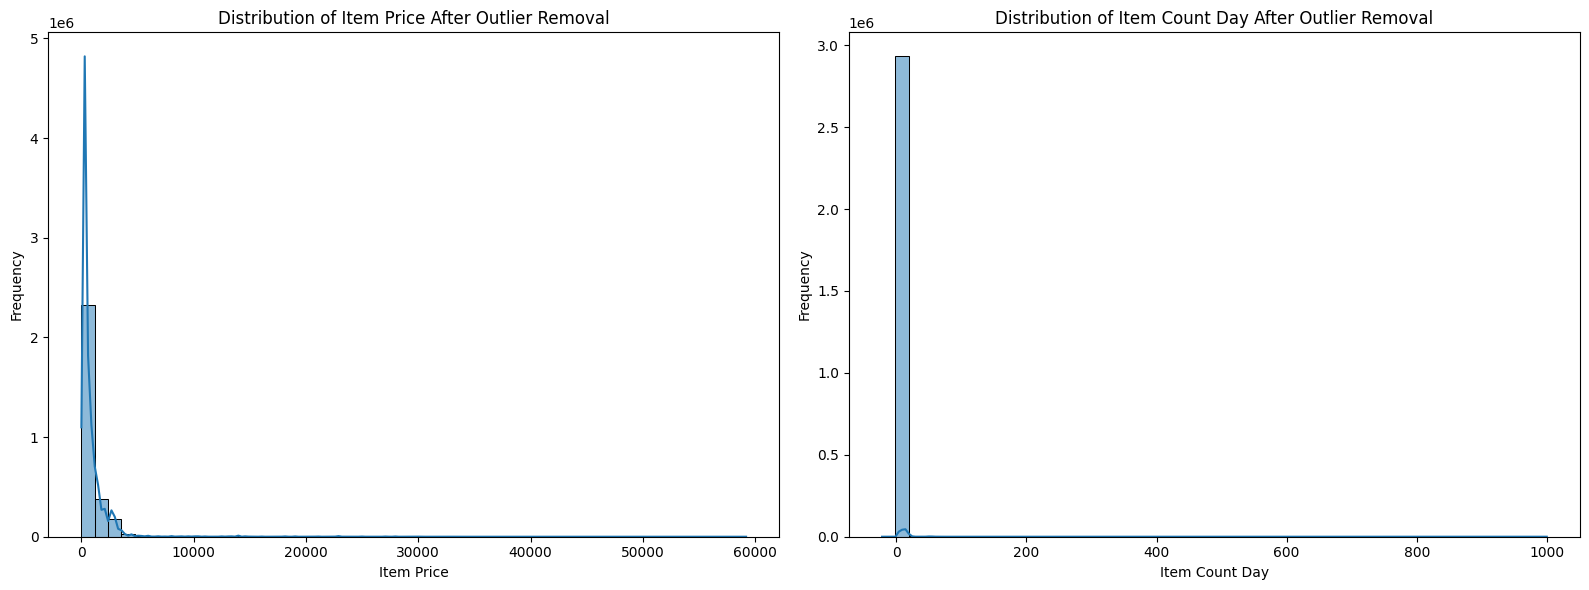

In [7]:
#plots of item price and item counts after the outlier removal
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['item_price'], bins=50, kde=True)
plt.title('Distribution of Item Price After Outlier Removal')
plt.xlabel('Item Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(train['item_cnt_day'], bins=50, kde=True)
plt.title('Distribution of Item Count Day After Outlier Removal')
plt.xlabel('Item Count Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
#filling an item price below zero with the median item price
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [9]:
# Handling Duplicate Shop Names
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [10]:
#Pre-processing of the shops, cats, and items tables
#columns created will be used for feature engineering. city_code and type_code will not be included in final model
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [11]:
#Prints the following: Unique items that appear in test set but not training set, unique items in test set, length of test set
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [12]:
#creating the month-by-month matrix to be used for feature engineering and model construction
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

11.327823162078857

In [13]:
#creating a revenue column to be used for feature engineering
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [14]:
#creating the target variable (item_cnt_month) and attaching it to the matrix
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
time.time() - ts

6.0568225383758545

In [15]:
#assign test rows to the next month (month 34)
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [16]:
#appending test values to the matrix to generate lag features (e.g., "what were sales last month")
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.08693742752075195

# Feature Engineering – Shops, Items, and Categories tables

In [17]:
#appending the variables from the shops, items, and cats tables for feature engineering
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.259171724319458

In [18]:
#creates a lag function to create past-value features for a column
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
#creates lag features on item_cnt_month for 1, 2, and 3 months ago
#how many units of this product sold 1 month ago, 2 months ago, etc.
ts = time.time()
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')
time.time() - ts

27.020061492919922

# Feature Engineering – Mean Encoded Features

In [20]:
# creates a feature that computes average sales of all items across all shops
# the feature that is kept is the lag = 1 feature, meaning we are capturing how items sold in the past month
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

8.484068393707275

In [21]:
# creates a feature to show how a specific item sold across all shops
# lag features are kept for 1, 2, and 3 months ago, capturing how a specific item sold in the past 1, 2, and 3 months, respectively
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

26.745790481567383

In [22]:
# creates a feature to show how all items in a specific shop sold in a certain month
# only lag features 1 and 2 are kept, meaning we capture how items sold in a specific shop last month and 2 months ago
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.646307706832886

In [23]:
# creates a feature to capture average sales of all items in a certain category in a certain month
# only lag feature 1 is kept, so we capture how a category performed last month
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.694049596786499

In [24]:
# creates a feature to capture avg sales of all items in a certain category, in a certain shop, in a certain month
# only lag feature 1 is kept, so we capture how shop-category combinations performed last month
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.933940887451172

In [25]:
# creates a feature to capture how an item sold in a certain city in a certain month
# keeps only the lag feature 1, so we capture how an item sold in a certain city last month
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.184672594070435

# Feature Engineering – Trends and Other Features

In [26]:
# finds price trend over time for pattern detection
# first finds overall average item prices, then monthly average item prices, creating lag features for the monthly prices
# then, % change from overall avg price is calculated and consolidated into a single trend feature = delta_price_lag
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

164.0719711780548

In [27]:
# creates a month variable that captures what month of the year it is for the model
matrix['month'] = matrix['date_block_num'] % 12

In [28]:
# creates a feature to capture the months since the last sale of an item in this shop
# the value will be -1 if never sold before
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
time.time() - ts

729.2370791435242

In [29]:
#does the same thing as the previous feature, but across all shops rather than shop-specific
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num
time.time() - ts

452.03575372695923

In [30]:
#creates features to show how many months it has been since the first time an item was sold in a specific shop
#second feature is how many months it has been since the first time an item was sold generally, across all shops
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.079714059829712

# Final Model Construction, XGBoost

In [31]:
# dropping first 3 months, as we used lag values up to 3.
ts = time.time()
matrix = matrix[matrix.date_block_num > 2]
time.time() - ts

2.2040774822235107

In [32]:
# handles null values produced by lag columns, especially those related to sales (item_cnt), which replaces null with 0
# replacing with 0 means that if there is no past data, assume sales were zero
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)
time.time() - ts

2.009547710418701

In [34]:
#columns in the final model
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'delta_price_lag', 'month',
       'item_shop_last_sale', 'item_last_sale', 'item_shop_first_sale',
       'item_first_sale'],
      dtype='object')

In [35]:
#info and data types for columns
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10005209 entries, 1122795 to 11128003
Data columns (total 26 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   date_block_num                     int8   
 1   shop_id                            int8   
 2   item_id                            int16  
 3   item_cnt_month                     float16
 4   city_code                          int8   
 5   item_category_id                   int8   
 6   type_code                          int8   
 7   subtype_code                       int8   
 8   item_cnt_month_lag_1               float16
 9   item_cnt_month_lag_2               float16
 10  item_cnt_month_lag_3               float16
 11  date_avg_item_cnt_lag_1            float16
 12  date_item_avg_item_cnt_lag_1       float16
 13  date_item_avg_item_cnt_lag_2       float16
 14  date_item_avg_item_cnt_lag_3       float16
 15  date_shop_avg_item_cnt_lag_1       float16
 16  date_shop_avg_i

In [36]:
#saving the model and deleting other tables
matrix.to_pickle('data2.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
gc.collect();

In [37]:
#reading the data back in from the saved file
data = pd.read_pickle('data2.pkl')

In [39]:
#ensuring the proper columns are selected
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'item_category_id',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [40]:
#splitting into training, validation, and test data
#train data is from month 3-32, validation is month 33, test is month 34
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [41]:
#delete the original dataframe for optimization, keeping only training, validation, and test subsets
del data
gc.collect();

In [42]:
#building the model and evaluating on rmse for training and validation sets
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.3,
    seed=42,
    eval_metric="rmse",
    early_stopping_rounds = 10)

model.fit(
    X_train,
    Y_train,
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True)

time.time() - ts

[0]	validation_0-rmse:1.06888	validation_1-rmse:1.02865
[1]	validation_0-rmse:0.99287	validation_1-rmse:0.98205
[2]	validation_0-rmse:0.94315	validation_1-rmse:0.94937
[3]	validation_0-rmse:0.91406	validation_1-rmse:0.93406
[4]	validation_0-rmse:0.89461	validation_1-rmse:0.93112
[5]	validation_0-rmse:0.88333	validation_1-rmse:0.92603
[6]	validation_0-rmse:0.87646	validation_1-rmse:0.92577
[7]	validation_0-rmse:0.87023	validation_1-rmse:0.92265
[8]	validation_0-rmse:0.86574	validation_1-rmse:0.92372
[9]	validation_0-rmse:0.86138	validation_1-rmse:0.92068
[10]	validation_0-rmse:0.85808	validation_1-rmse:0.91866
[11]	validation_0-rmse:0.85559	validation_1-rmse:0.91901
[12]	validation_0-rmse:0.85372	validation_1-rmse:0.91908
[13]	validation_0-rmse:0.85130	validation_1-rmse:0.92187
[14]	validation_0-rmse:0.84965	validation_1-rmse:0.92118
[15]	validation_0-rmse:0.84825	validation_1-rmse:0.92096
[16]	validation_0-rmse:0.84714	validation_1-rmse:0.92062
[17]	validation_0-rmse:0.84619	validation

42.268821716308594

In [43]:
# predicting y values based on the model
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": Y_test
})
submission.to_csv('pfs_submission2.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

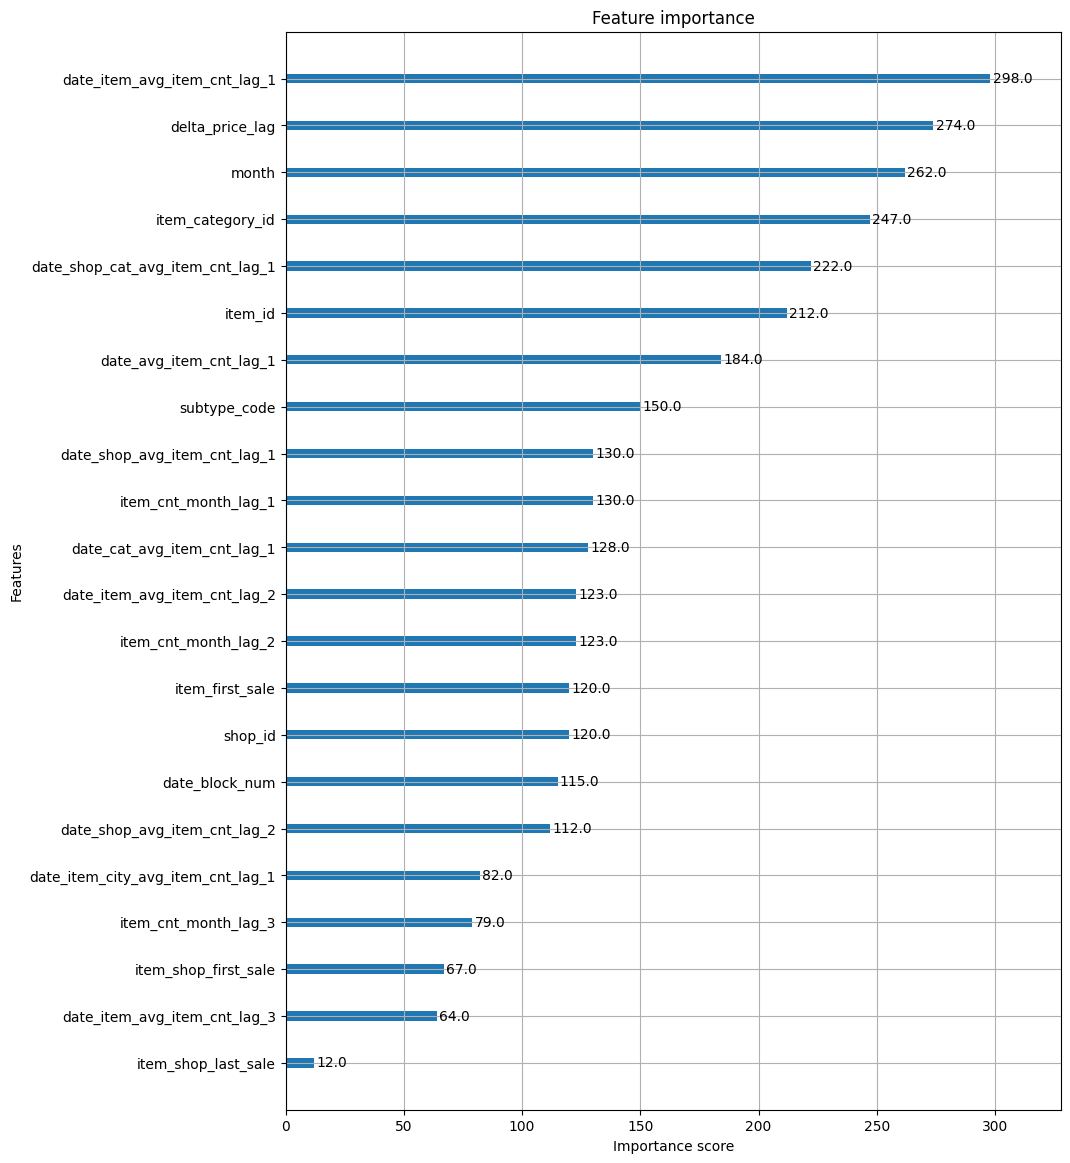

In [44]:
#feature importance graph
plot_features(model, (10,14))